# Imports

In [25]:
import tensorflow as tf
tf.__version__

'1.4.0'

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build toy data set

In [27]:
def build_toy_dataset(N, noise_std=2):  
    x = np.ones([N, 2])
    x[:, 0] = np.linspace(-2, 2, N)    
    w = np.array([-0.5, 1])
    y = np.dot(x, w) + np.random.randn(N)*noise_std
    return x, y

N = 200  # number of data points
D = 2
noise_std = 2

x_train, y_train = build_toy_dataset(N, noise_std=noise_std)
x_test, y_test = build_toy_dataset(N, noise_std=noise_std)
x_train.shape, y_train.shape

((200, 2), (200,))

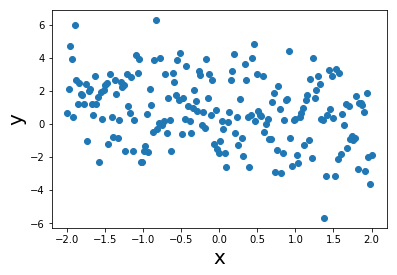

In [28]:
plt.plot(x_train[:, 0], y_train, 'o')
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)

# Define priors on parameters w and b

In [29]:
from edward.models import Normal
import edward as ed

X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
y = Normal(loc=ed.dot(X, w), scale=tf.ones(N))

In [30]:
X, w, y

(<tf.Tensor 'Placeholder_1:0' shape=(200, 2) dtype=float32>,
 <ed.RandomVariable 'Normal_3/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'Normal_4/' shape=(200,) dtype=float32>)

## Define posteriors

In [31]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

# Run edward inference 

In [32]:
inference = ed.KLqp({w: qw}, data={X: x_train, y: y_train})
inference.run(n_samples=15, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 564.391


In [33]:
y_post = ed.copy(y, {w: qw})

In [34]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: x_test, y_post: y_test}))

Mean squared error on test data:
4.11134
Mean absolute error on test data:
1.68238


In [35]:
sess = tf.get_default_session()
for i in range(10):
    print(sess.run(y_post, feed_dict={X: x_test}).sum())

172.935
150.518
200.627
183.095
163.744
138.111
151.181
157.094
152.882
182.715


In [36]:
def visualise(X_data, y_data, w, n_samples=10):
    w_samples = w.sample(n_samples).eval()        
    plt.scatter(X_data[:, 0], y_data)    
    for ns in range(n_samples):        
        output = np.dot(X_data, w_samples[ns])
        plt.plot(X_data[:, 0], output, 'r-', alpha=0.4)

# Visualize samples from the prior

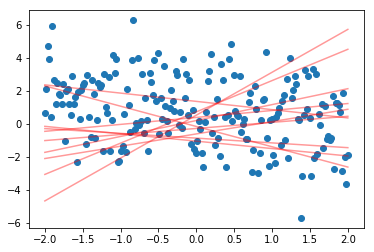

In [38]:
visualise(x_train, y_train, w)

# Visualize samples from the posterior

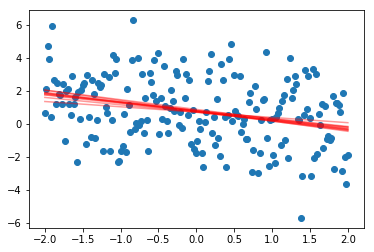

In [39]:
visualise(x_train, y_train, qw)

# Print posteriors params

In [22]:
qw.mean().eval(), qw.stddev().eval()

(array([-0.65671128,  1.21147692], dtype=float32),
 array([ 0.05385412,  0.07110237], dtype=float32))